In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_2.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_7.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_5.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_10.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_1.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_8.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_3.JPG
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_6.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_9.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/I

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2024-04-11 12:34:01.487037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 12:34:01.487155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 12:34:01.595237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
train_dir = Path('../input/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [4]:
test_dir = Path('../input/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
val_dir = Path('../input/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [6]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')


    df = pd.concat([filepath, labels], axis=1)


    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [7]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

In [ ]:
train_df.head(5)

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [13]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

In [15]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [31]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

ValueError: The name "input_layer" is used 2 times in the model. All operation names should be unique.

In [17]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 


['cauliflower',
 'corn',
 'bell pepper',
 'cabbage',
 'pineapple',
 'watermelon',
 'cucumber',
 'pomegranate',
 'tomato',
 'banana',
 'soy beans',
 'paprika',
 'orange',
 'pear',
 'turnip',
 'soy beans',
 'cucumber',
 'paprika',
 'peas',
 'ginger',
 'garlic',
 'ginger',
 'sweetcorn',
 'turnip',
 'garlic',
 'lettuce',
 'soy beans',
 'pear',
 'carrot',
 'banana',
 'watermelon',
 'bell pepper',
 'mango',
 'garlic',
 'jalepeno',
 'jalepeno',
 'sweetcorn',
 'pomegranate',
 'potato',
 'watermelon',
 'pear',
 'pineapple',
 'pear',
 'kiwi',
 'pineapple',
 'pineapple',
 'jalepeno',
 'apple',
 'cucumber',
 'peas',
 'lettuce',
 'lettuce',
 'watermelon',
 'capsicum',
 'lemon',
 'watermelon',
 'mango',
 'beetroot',
 'sweetpotato',
 'paprika',
 'grapes',
 'kiwi',
 'sweetcorn',
 'peas',
 'pomegranate',
 'sweetcorn',
 'watermelon',
 'capsicum',
 'pineapple',
 'cucumber',
 'onion',
 'onion',
 'peas',
 'watermelon',
 'turnip',
 'sweetcorn',
 'paprika',
 'potato',
 'watermelon',
 'soy beans',
 'raddish',

In [18]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [19]:
img = output('../input/fruit-and-vegetable-image-recognition/test/cabbage/Image_1.jpg')
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


'cabbage'

In [20]:
model.save('FV.h5')

In [21]:
def plot_model_history(model_history, out_path=""):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(range(1, len(model_history.history['accuracy']) + 1))
    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(range(1, len(model_history.history['loss']) + 1))
    axs[1].legend(['train', 'val'], loc='best')

    plt.savefig(out_path + "/acc_loss.png")
    plt.show
    
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8})
    if out_path:
        plt.savefig(out_path + "/confusion_matrix.png")
    return ax

NameError: name 'y_pred' is not defined

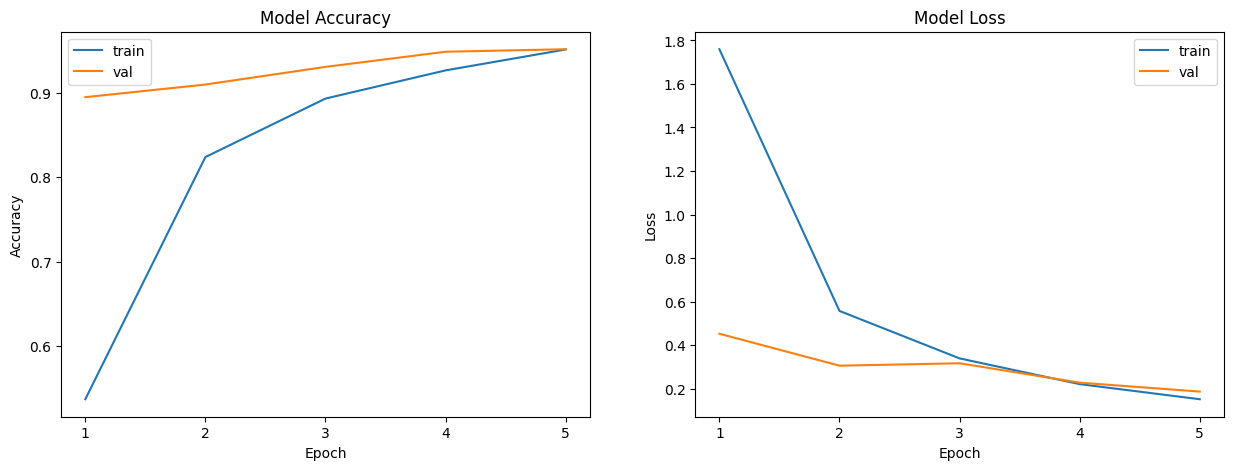

In [23]:
model_out_dir = '/kaggle/working/'
plot_model_history(history, out_path=model_out_dir)

In [ ]:
from keras.models import load_model
model = load_model('FV.h5')
model.summary()
model.get_weights()

In [1]:
import keras.backend as K

# Get a list of all functions and attributes in keras.backend
all_functions_and_attributes = dir(K)

# Print the list
print(all_functions_and_attributes)


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'abs', 'all', 'any', 'arange', 'argmax', 'argmin', 'backend', 'batch_dot', 'batch_flatten', 'batch_get_value', 'batch_normalization', 'batch_set_value', 'bias_add', 'binary_crossentropy', 'binary_focal_crossentropy', 'cast', 'cast_to_floatx', 'categorical_crossentropy', 'categorical_focal_crossentropy', 'clear_session', 'clip', 'concatenate', 'constant', 'conv1d', 'conv2d', 'conv2d_transpose', 'conv3d', 'cos', 'count_params', 'ctc_batch_cost', 'ctc_decode', 'ctc_label_dense_to_sparse', 'cumprod', 'cumsum', 'depthwise_conv2d', 'dot', 'dropout', 'dtype', 'elu', 'epsilon', 'equal', 'eval', 'exp', 'expand_dims', 'experimental', 'eye', 'flatten', 'floatx', 'foldl', 'foldr', 'function', 'gather', 'get_uid', 'get_value', 'gradients', 'greater', 'greater_equal', 'hard_sigmoid', 'image_data_format', 'in_test_phase', 'in_top_k', 'in_train_phase', 'int_shape', 'is_keras_tensor',

In [3]:
import keras
print(keras.__version__)

2.15.0


In [4]:
!pip list

Package                      Version
---------------------------- --------------------
absl-py                      2.1.0
altair                       5.3.0
asttokens                    2.4.1
astunparse                   1.6.3
attrs                        23.2.0
audioread                    3.0.1
beautifulsoup4               4.12.3
blinker                      1.7.0
cachetools                   5.3.3
certifi                      2023.11.17
cffi                         1.15.1
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.8.1
decorator                    5.1.1
executing                    2.0.1
filelock                     3.13.3
Flask                        3.0.2
flatbuffers                  23.5.26
fonttools                    4.42.1
fsspec                       2024.3.1
gast                  


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import tensorflow
print(tensorflow.__version__)

2.15.0
